## IMPORTING LIBRARIES

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the `train.csv` dataset

data = pd.read_csv('paddy-disease-classification/train.csv')

In [3]:
# Print the 5 rows of the dataset

data.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [4]:
data.shape


(10407, 4)

## DATA PREPROCESSING

### Check Missing values & Duplicates

In [5]:
data.isnull().sum()

image_id    0
label       0
variety     0
age         0
dtype: int64

In [6]:
# Check for duplicates
data.duplicated().sum()

0

#### No missing and duplicated values

In [7]:
data['label'].unique().tolist()

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [8]:
data['age'].describe()

count    10407.000000
mean        64.043624
std          8.958830
min         45.000000
25%         60.000000
50%         67.000000
75%         70.000000
max         82.000000
Name: age, dtype: float64

## Visualization

d:\Anaconda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


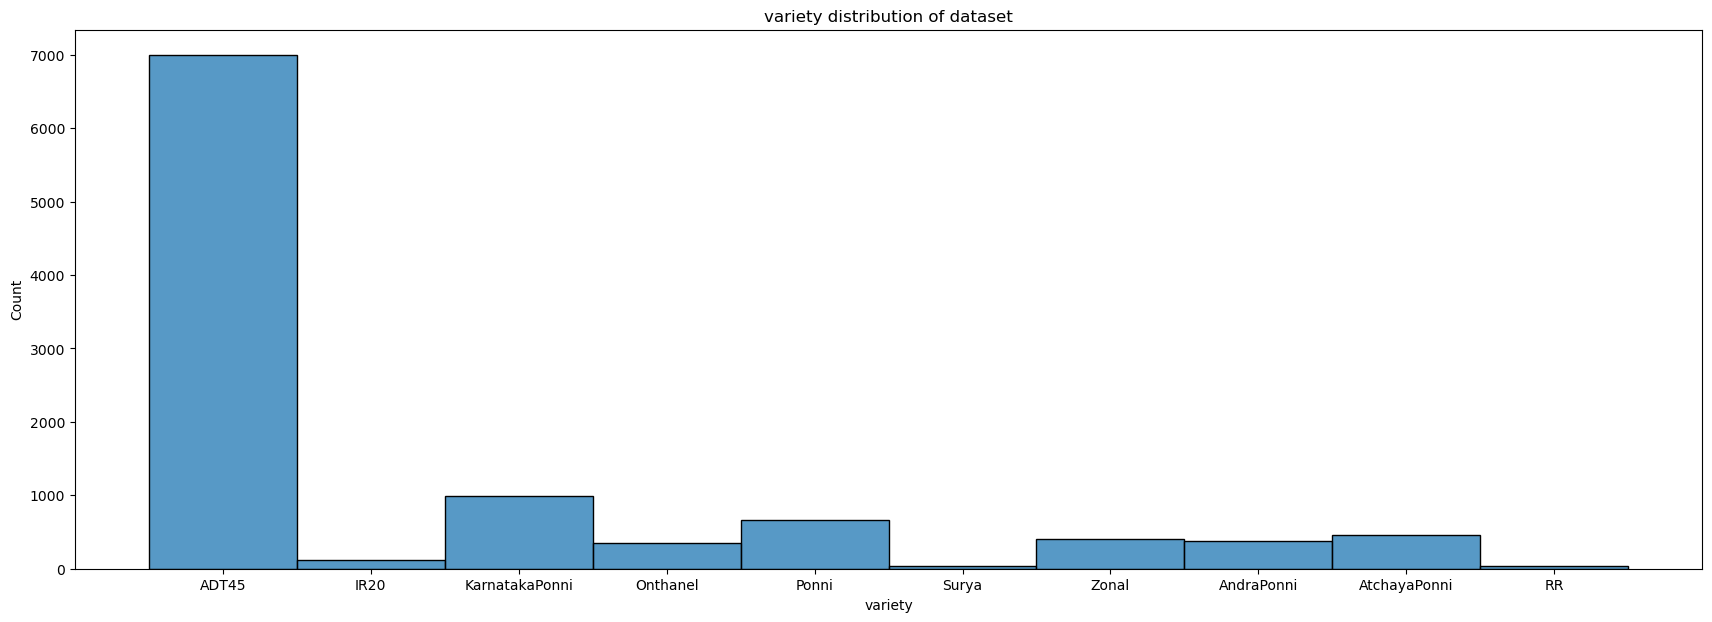

In [9]:
# Plot the variations of the Plants

fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='variety', ax=axes)
plt.title('variety distribution of dataset')
plt.show()

d:\Anaconda\envs\tf-gpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


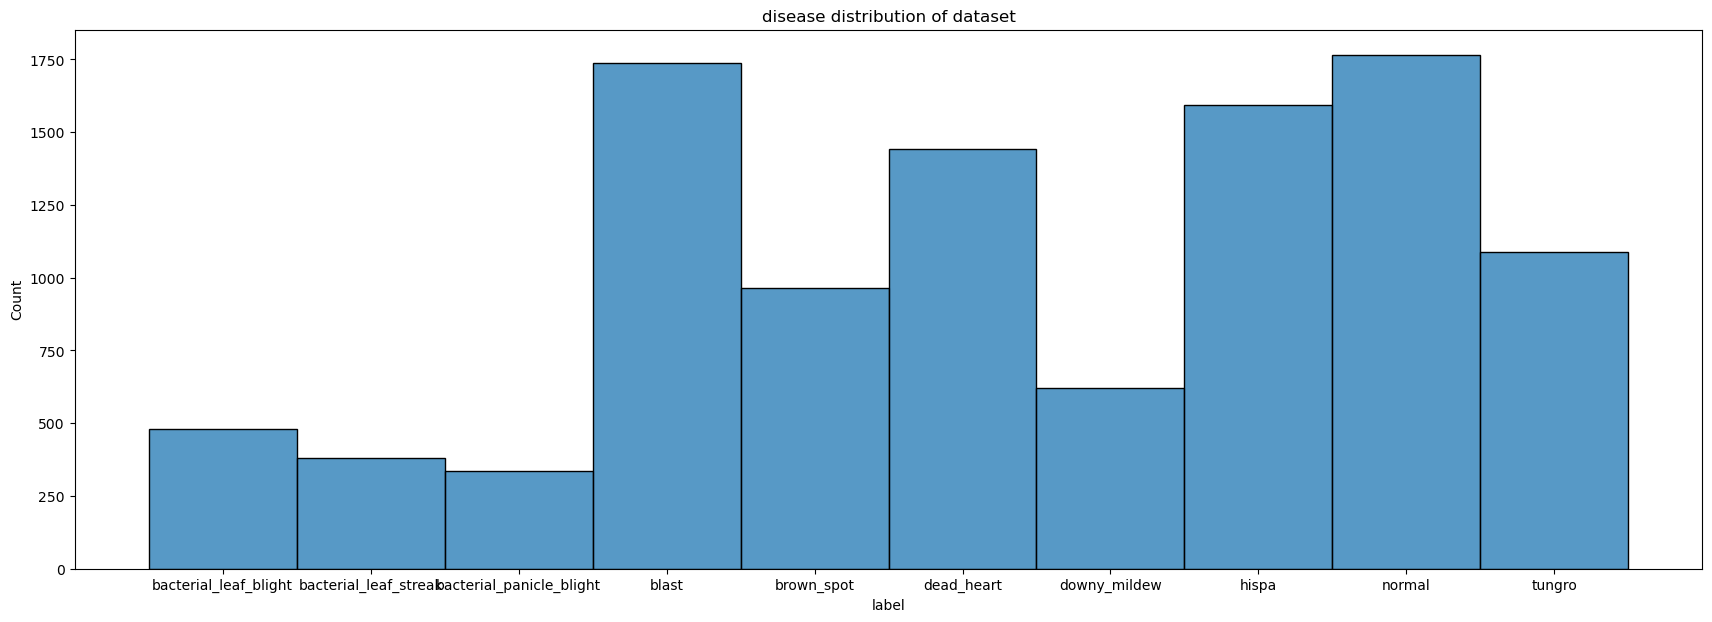

In [10]:
# Plot labels

fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='label', ax=axes)
plt.title('disease distribution of dataset')
plt.show()

In [11]:
# Define normal plants

normal = data[data['label']=='normal']
normal = normal[normal['variety']=='ADT45']
five_normals = normal.image_id[:5].values
five_normals.tolist()

['100007.jpg', '100025.jpg', '100135.jpg', '100165.jpg', '100171.jpg']

In [12]:
# Define deads

dead = data[data['label']=='dead_heart']
dead = dead[dead['variety']=='ADT45']
five_deads = dead.image_id[:5].values
five_deads.tolist()

['101165.jpg', '102750.jpg', '108367.jpg', '109900.jpg', '100222.jpg']

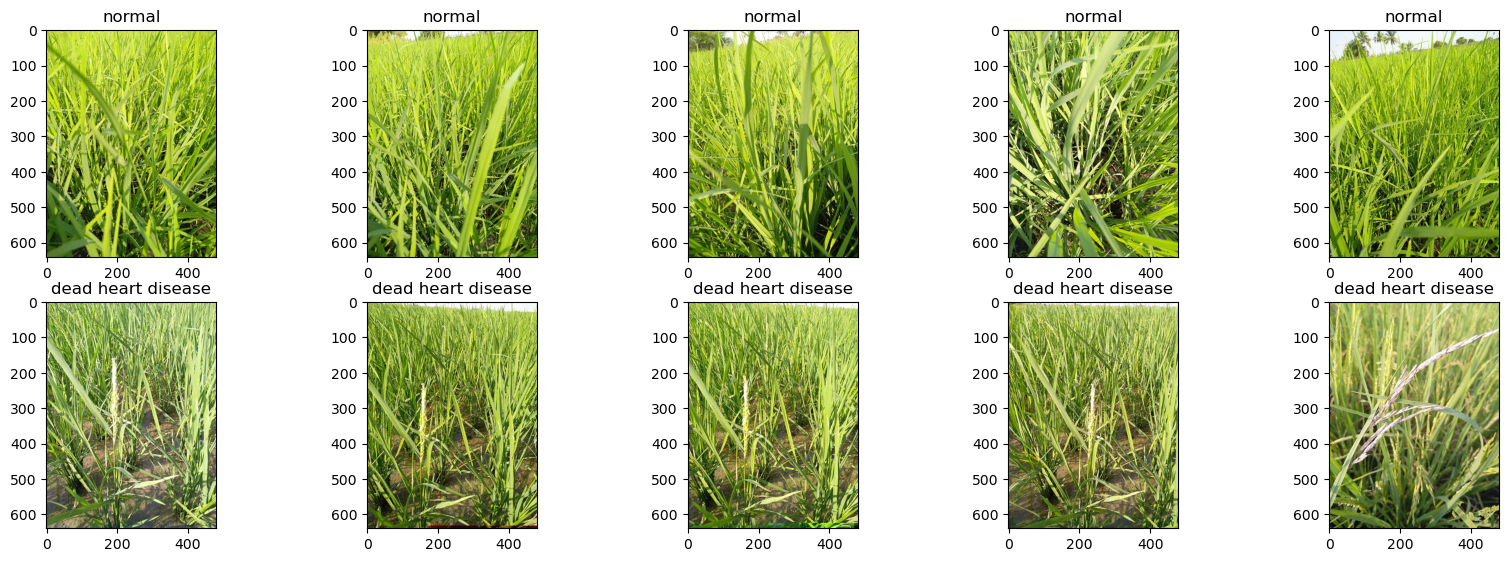

In [13]:
# Print some noraml images of paddy and dead heart disease paddy

plt.figure(figsize=(20,10))
columns = 5

path = 'paddy-disease-classification/train_images'

for i, image_loc in enumerate(np.concatenate((five_normals, five_deads))):
    plt.subplot(10 // columns + 1, columns, i + 1)
    if i < 5:
        image = plt.imread(path + "/normal/" + image_loc)
        plt.title("normal")
    else:
        plt.title("dead heart disease")
        image = plt.imread(path + "/dead_heart/" + image_loc)
    plt.imshow(image)

plt.show()

In [14]:
# Define the parameters

batch_size = 16
img_height = 224
img_width = 224

### Train and test split of data

In [15]:
# Importing training data 

train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [16]:
# Importing validation data

val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [17]:
# Print the class names

Class_names = train_ds.class_names
print(Class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


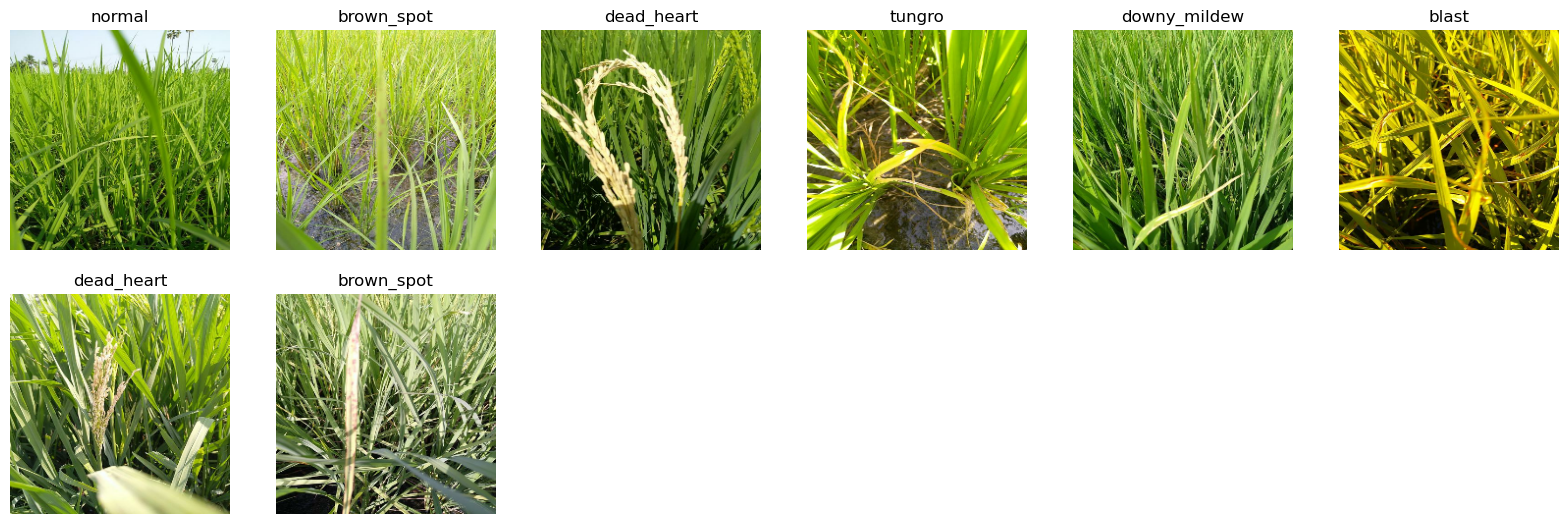

In [18]:
# Plotting images of all classes
# Creating a new figure with a specified size

plt.figure(figsize=(20,20))

# Taking the first batches of images and labels in the train dataset

for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(6,6,i+1)
    
    # Displaying the image using imshow() function
    
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(Class_names[labels[i]])
    plt.axis("off")

In [19]:
# Print the shape of images and label

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


#####  CNN MODEL CREATION  First diamention 32 represent batch size .  224, 224 are the value for height and weight and 3 is the number of color channels in each image(RGB)

### Image Normalization

In [20]:
# normalizing pixel values of input images

normalization_layer = tf.keras.layers.Rescaling(1./255)

In [21]:
# Applying normalization layer to each batch of images 

normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))

# retrieves the first batch of normalized images and their corresponding labels

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0] 

# prints the minimum and maximum pixel values of first images
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Parameter Tuning

In [22]:
# Enable automatic tuning of parameters by TensorFlow.
AUTOTUNE = tf.data.AUTOTUNE

#optimizes the training dataset 
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) #caches the elements of the dataset in memory
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #prefetches elements from the dataset into memory

##  MODEL 1

In [23]:
num_classes = len(Class_names)
model1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    
    #Step 1 - Convolution
    tf.keras.layers.Conv2D(64,3,activation='relu'),
    # Step 2 - Pooling
    tf.keras.layers.MaxPooling2D(),
    
    # Second layer
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # Step 3 - Flattening
    tf.keras.layers.Flatten(),
    
    # Step 4 - Full Connection
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
model1.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),  
    metrics=['accuracy']  
)

In [25]:
#define the callback function
early_stopping = EarlyStopping(patience=10)

history = model1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10


d:\Anaconda\envs\tf-gpu\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


521/521 [==============================] - 162s 290ms/step - loss: 1.9965 - accuracy: 0.2914 - val_loss: 1.7772 - val_accuracy: 0.3820
Epoch 2/10
521/521 [==============================] - 306s 587ms/step - loss: 1.3947 - accuracy: 0.5389 - val_loss: 1.5857 - val_accuracy: 0.4868
Epoch 3/10
521/521 [==============================] - 301s 578ms/step - loss: 0.9322 - accuracy: 0.6958 - val_loss: 1.7293 - val_accuracy: 0.5103
Epoch 4/10
521/521 [==============================] - 292s 561ms/step - loss: 0.6088 - accuracy: 0.8011 - val_loss: 1.6725 - val_accuracy: 0.5709
Epoch 5/10
521/521 [==============================] - 288s 552ms/step - loss: 0.4201 - accuracy: 0.8610 - val_loss: 1.8814 - val_accuracy: 0.5728
Epoch 6/10
521/521 [==============================] - 281s 541ms/step - loss: 0.2924 - accuracy: 0.9043 - val_loss: 2.1215 - val_accuracy: 0.6103
Epoch 7/10
521/521 [==============================] - 280s 537ms/step - loss: 0.2010 - accuracy: 0.9341 - val_loss: 2.1580 - val_accura

In [34]:
print("Last Epoch Training Accuracy:", history.history['accuracy'][9]*100)
print("Last Epoch Validation Accuracy:", history.history['val_accuracy'][9]*100)
print("Last Epoch Training Loss:", history.history['loss'][9])
print("Last Epoch Validation Loss:", history.history['val_loss'][9])

Last Epoch Training Accuracy: 97.00936675071716
Last Epoch Validation Accuracy: 63.81547451019287
Last Epoch Training Loss: 0.10265845060348511
Last Epoch Validation Loss: 2.485922336578369


## MODEL 2 CNN

In [36]:
num_classes = len(Class_names)
model2 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    
    #Step 1 - Convolution
    tf.keras.layers.Conv2D(64,3,activation='relu'),
    
    # Step 2 - Pooling
    tf.keras.layers.MaxPooling2D(),
     
    # Second layer
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Third layer
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # Fourth layer
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # Step 3 - Flattening
    tf.keras.layers.Flatten(),
    
    # Step 4 - Full Connection
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [37]:
model2.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),  
    metrics=['accuracy']  
)

In [38]:
#define the callback function
early_stopping = EarlyStopping(patience=10)

history_1 = model2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[early_stopping])

Epoch 1/20


d:\Anaconda\envs\tf-gpu\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


521/521 [==============================] - 242s 460ms/step - loss: 2.0155 - accuracy: 0.2634 - val_loss: 1.6960 - val_accuracy: 0.4113
Epoch 2/20
521/521 [==============================] - 259s 497ms/step - loss: 1.4989 - accuracy: 0.4835 - val_loss: 1.2634 - val_accuracy: 0.5766
Epoch 3/20
521/521 [==============================] - 248s 476ms/step - loss: 1.0412 - accuracy: 0.6521 - val_loss: 1.0315 - val_accuracy: 0.6843
Epoch 4/20
521/521 [==============================] - 249s 479ms/step - loss: 0.7312 - accuracy: 0.7562 - val_loss: 0.9324 - val_accuracy: 0.7251
Epoch 5/20
521/521 [==============================] - 264s 508ms/step - loss: 0.5490 - accuracy: 0.8186 - val_loss: 0.8204 - val_accuracy: 0.7756
Epoch 6/20
521/521 [==============================] - 267s 513ms/step - loss: 0.4182 - accuracy: 0.8643 - val_loss: 0.8306 - val_accuracy: 0.7958
Epoch 7/20
521/521 [==============================] - 254s 488ms/step - loss: 0.3338 - accuracy: 0.8909 - val_loss: 0.9185 - val_accura

In [39]:
print("Last Epoch Training Accuracy:", history_1.history['accuracy'][14])
print("Last Epoch Validation Accuracy:", history_1.history['val_accuracy'][14])
print("Last Epoch Training Loss:", history_1.history['loss'][14])
print("Last Epoch Validation Loss:", history_1.history['val_loss'][14])

Last Epoch Training Accuracy: 0.9682921171188354
Last Epoch Validation Accuracy: 0.8159538507461548
Last Epoch Training Loss: 0.10224854946136475
Last Epoch Validation Loss: 1.0741628408432007


In [40]:
# evaluate the model
loss = model2.evaluate(val_ds)

131/131 [==============================] - 12s 90ms/step - loss: 1.0742 - accuracy: 0.8160


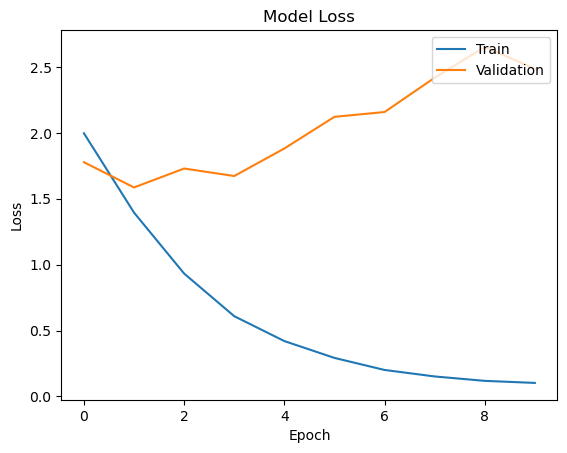

CPU times: total: 328 ms
Wall time: 704 ms


In [41]:
%%time
#remove warning
import warnings
warnings.filterwarnings('ignore')

# plotting the training and testing loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # corrected the typo in this line
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()  

In [6]:
import os
import numpy as np
from PIL import Image

image_dir = 'paddy-disease-classification/test_images'

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

classes = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 
               'bacterial_panicle_blight', 'blast', 'brown_spot', 
               'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

model2 = tf.keras.models.load_model('cnn.keras')

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((224, 224))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model2.predict(img_array)[0]
    index = np.argmax(prediction)
    confidence = int(prediction[index]*100)
    disease = classes[index]
    print(f'Disease : {disease}, confidence : {confidence}]')


1/1 [==============================] - 6s 6s/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 39ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 59ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 108ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 48ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 45ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 50ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 33ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 62ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 104ms/step
Disease : brown_spot, confidence : 100]
1/1 [==============================] - 0s 29ms/step
Disease : brown_spot, confid

In [43]:
model2.save('cnnModel.keras')